<a href="https://colab.research.google.com/github/Ayan-Vishwakarma/CapsuleNetwork/blob/main/CapsuleNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This model is an instance of the paper presented by Sir Geoffrey E. Hinton [ https://arxiv.org/pdf/1710.09829.pdf] on Capsule networks, which was able to reach the best performance on Mnist dataset at that time using only 3 neuron layers ,which previously required deep convolutional networks to reach the same accuracy score.

The benefit of capsule networks is the less number of parameters required rather than large deep networks for processing, with a overhead of dynamic routing which may take more or less time than convolutional neural networks based on number of capsule layers and number of iterations on dynamic routing process, but generally faster than conventional neural network architectures.

However, at this time ,Capsule network can perform good only on tasks where inverse rendering is possible , such as classifying shapes, digits [ mnist and multi-mnist dataset ], boundaries etc. ,i.e., anything that can be approximately rendered by a computer . In complicated tasks, like classifying image of cats, this model simply fails due to inability to inverse render the image of cats [ NO fixed shape, No fixed posture, No fixed colour ] .

# Importing libraries and dataset

In [ ]:
!pip install optuna
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import optuna as optuna
from tensorflow.keras.utils import plot_model
from IPython.display import clear_output 
import time as time

     |████████████████████████████████| 296kB 14.5MB/s 
     |████████████████████████████████| 1.1MB 56.3MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
     |████████████████████████████████| 481kB 50.4MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 112kB 60.7MB/s 
     |████████████████████████████████| 143kB 63.1MB/s 
  Created wheel for alembic: filename=alembic-1.5.4-py2.py3-none-any.whl size=156314 sha256=ad66f5adc8ca52a5c0c4283b77a592300afc92ba4215db4b8d43db38041e79b9
  Stored in directory: /root/.cache/pip/wheels/fd/2d/ec/5a1b1e2363ed68392d292d215facf588d5448198edd8078bc1
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=20b7cd50c34f4a4f032e5c3b3acf75e90913340e8e4bf64a4a86122a998e6575
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 s

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Loading Mnist Dataset

In [ ]:
train,test = mnist.load_data()
yt = np.array(train[1],dtype=np.uint8)
xt = []
for i in range(len(train[0])):
    xt.append(np.array(train[0][i].reshape((28,28,1)),dtype=np.float32))
    
del train
xt = np.array(xt)
xval = xt[55000:]
yval = yt[55000:]
xt = xt[:55000]
yt = yt[:55000]
print("Training set size:",len(xt))
print("Validation set size:",len(xval))

11493376/11490434 [==============================] - 0s 0us/step
Training set size: 55000
Validation set size: 5000


Label: 3


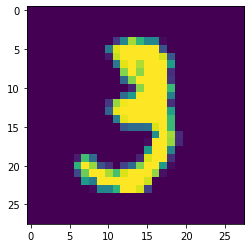

In [ ]:
i = 10

#########################################################################################################################################

plt.imshow(xt[i].reshape(28,28))
print("Label:",yt[i])

# Custom keras layers for Squashing and Dynamic Routing with some additions

_________________________________________________________________________
1.Rsh() layer ----------> Squashes the last axis of input Tensor.

2.DR_GC(ocap,vecsize,n_iter,typ,branch) layer -------------> 
Dynamic Routing layer.

> Takes (None, height, width, capsules, vector_size) input.

> Returns (None,out_capsules,out_vector_size) output.

3.DR_NR(ocap,vecsize,n_iter,typ) layer -------------->
Dynamic Routing layer.

> Takes (None, height, width, capsules, vector_size) input.

> Returns (None,height,width,out_capsules,out_vector_size) output.

__________________________________________________________________________

________________________________________________________________________
typ : Defines type to be used. 
> Auto gives each image pixel a unique weight.

> Paper gives each image pixel shared weight [As used in CapsNet paper].

branch : Defines method to combine image pixels.
> mean : Takes average of all the pixel capsules.

> max : Takes the highest value of capsule in given image.
_______________________________________________________________________


In [ ]:
#########################################################################################################################################
#                                                   Squashing Layer
#########################################################################################################################################
class Rsh(tf.keras.layers.Layer):
    def __init__(self):
        super(Rsh,self).__init__()
    def call(self,input_data):
        self.temp = tf.reduce_sum(input_data*input_data,axis=-1,keepdims=True)
        self.temp = tf.nn.softsign(self.temp)
        input_data = tf.math.l2_normalize(input_data,axis=-1)
        return input_data*self.temp
########################################################################################################################################

In [ ]:
#########################################################################################################################################
#                             GENERAL CASE:  Dynamic Routing Layer with additional modifications w.r.t. Capsnet architecture        
#########################################################################################################################################
# Takes output capsules and vector size of each capsule and returns a (None,ocap,vecsize) dimensional output.
# Here, it reduces the image dimensions
class DR_GC(tf.keras.layers.Layer):
    def __init__(self,ocap,vecsize,n_iter=40,branch="mean",typ="auto"):
        super(DR_GC,self).__init__()
        self.ocap = ocap
        self.vecsize = vecsize
        self.branch = str(branch)
        self.typ = str(typ)
        self.n_iter=n_iter  
    def build(self,input_shape):
      self.sh = input_shape
      if self.typ == "paper":
        self.w = tf.Variable(np.random.normal(size=(input_shape[-1],self.ocap,self.vecsize),scale=(0.01)),name="DRV",trainable=True,dtype=tf.float32)
      else :
        self.w = tf.Variable(np.random.normal(size=(input_shape[-1],self.ocap,self.vecsize),scale=(0.3)),name="DRV",trainable=True,dtype=tf.float32)
      super(DR_GC,self).build(input_shape)
    def call(self,input_data):
      if self.typ == "auto":
          self.data = tf.tensordot(input_data,self.w,axes=1)
          self.b = tf.zeros((1,self.sh[1],self.sh[2],self.sh[3],self.ocap,1),dtype = tf.float32)
          self.c = tf.ones((1,self.sh[1],self.sh[2],self.sh[3],self.ocap,1),tf.float32) * (1/self.sh[3])
          for i in range(self.n_iter):
              self.v = tf.reduce_sum(self.data * self.c,axis=-3,keepdims=True)
              self.a = tf.reduce_sum(self.v * self.data,axis=-1,keepdims=True)
              self.b = tf.math.add(self.b,self.a)
              self.c = tf.nn.softmax(self.b,axis=-3)
          self.v = tf.reduce_sum(self.data * self.c,axis=-3,keepdims=False)
          if self.branch == "mean":
              self.v = tf.math.reduce_mean(self.v,axis=-3,keepdims=False)
              self.v = tf.math.reduce_mean(self.v,axis=-3,keepdims=False)
          elif self.branch == "max":
              self.tmp = tf.nn.softsign(tf.math.reduce_sum(self.v * self.v,axis=-1,keepdims=True))
              self.tmp = tf.math.argmax(self.v,axis=-3)
              self.tmp = tf.one_hot(self.tmp,self.sh[2],axis=2)
              self.v = tf.math.reduce_max(self.tmp * self.v,axis=-3,keepdims=False)
              self.tmp = tf.nn.softsign(tf.math.reduce_sum(self.v * self.v,axis=-1,keepdims=True))
              self.tmp = tf.math.argmax(self.v,axis=-3)
              self.tmp = tf.one_hot(self.tmp,self.sh[1],axis=1)
              self.v = tf.math.reduce_max(self.tmp * self.v,axis=-3,keepdims=False)
          return self.v
      elif self.typ == "paper":
          self.data = tf.tensordot(input_data,self.w,axes=1)
          self.b = tf.zeros((1,self.sh[1],self.sh[2],self.sh[3],self.ocap,1),dtype = tf.float32)
          self.c = tf.ones((1,self.sh[1],self.sh[2],self.sh[3],self.ocap,1),tf.float32) * (1/self.sh[3])
          for i in range(self.n_iter):
              self.v = tf.reduce_sum(self.data * self.c,axis=-3,keepdims=True)
              self.a = tf.reduce_sum(self.v * self.data,axis=-1,keepdims=True)
              self.a = tf.reduce_sum(self.v * self.data,axis=-4,keepdims=True)
              self.a = tf.reduce_sum(self.v * self.data,axis=-5,keepdims=True)
              self.b = tf.math.add(self.b,self.a)
              self.c = tf.nn.softmax(self.b,axis=-3)
          self.v = tf.reduce_sum(self.data * self.c,axis=-3,keepdims=False)
          self.v = tf.math.reduce_sum(self.v,axis=-3,keepdims=False)
          self.v = tf.math.reduce_sum(self.v,axis=-3,keepdims=False)
          return self.v
#########################################################################################################################################

In [ ]:
#########################################################################################################################################
#               GENERAL CASE :: NO Reduction:  Dynamic Routing Layer with additional modifications w.r.t. Capsnet architecture        
#########################################################################################################################################
# Takes output capsules and vector size of each capsule and returns a (None,input_dims[1],input_dims[2],ocap,vecsize) dimensional output.
# Here, it does not reduces the image dimensions
class DR_NR(tf.keras.layers.Layer):
    def __init__(self,ocap,vecsize,n_iter=40,typ="auto"):
        super(DR_NR,self).__init__()
        self.ocap = ocap
        self.vecsize = vecsize
        self.typ = str(typ)
        self.n_iter=n_iter  
    def build(self,input_shape):
      self.sh = input_shape
      if self.typ == "paper":
        self.w = tf.Variable(np.random.normal(size=(input_shape[-1],self.ocap,self.vecsize),scale=(0.01)),name="DRV",trainable=True,dtype=tf.float32)
      else :
        self.w = tf.Variable(np.random.normal(size=(input_shape[-1],self.ocap,self.vecsize),scale=(0.3)),name="DRV",trainable=True,dtype=tf.float32)
      super(DR_NR,self).build(input_shape)
    def call(self,input_data):
      if self.typ == "auto":
          self.data = tf.tensordot(input_data,self.w,axes=1)
          self.b = tf.zeros((1,self.sh[1],self.sh[2],self.sh[3],self.ocap,1),dtype = tf.float32)
          self.c = tf.ones((1,self.sh[1],self.sh[2],self.sh[3],self.ocap,1),tf.float32) * (1/self.sh[3])
          for i in range(self.n_iter):
              self.v = tf.reduce_sum(self.data * self.c,axis=-3,keepdims=True)
              self.a = tf.reduce_sum(self.v * self.data,axis=-1,keepdims=True)
              self.b = tf.math.add(self.b,self.a)
              self.c = tf.nn.softmax(self.b,axis=-3)
          self.v = tf.reduce_sum(self.data * self.c,axis=-3,keepdims=False)
          return self.v
      elif self.typ == "paper":
          self.data = tf.tensordot(input_data,self.w,axes=1)
          self.b = tf.zeros((1,self.sh[1],self.sh[2],self.sh[3],self.ocap,1),dtype = tf.float32)
          self.c = tf.fill((1,self.sh[1],self.sh[2],self.sh[3],self.ocap,1),tf.float32) * (1/self.sh[3])
          for i in range(self.n_iter):
              self.v = tf.reduce_sum(self.data * self.c,axis=-3,keepdims=True)
              self.a = tf.reduce_sum(self.v * self.data,axis=-1,keepdims=True)
              self.a = tf.reduce_sum(self.v * self.data,axis=-4,keepdims=True)
              self.a = tf.reduce_sum(self.v * self.data,axis=-5,keepdims=True)
              self.b = tf.math.add(self.b,self.a)
              self.c = tf.nn.softmax(self.b,axis=-3)
          self.v = tf.reduce_sum(self.data * self.c,axis=-3,keepdims=False)
          return self.v
#########################################################################################################################################

# Model without Reconstruction Regularization

Loss Definition

In [ ]:
#########################################################################################################################################
#                                               SVM (Hinge) loss 
#########################################################################################################################################
def svm_hinge(labels,logits):
  labels = tf.squeeze(tf.one_hot(labels,depth=10))
  x = tf.math.reduce_max(labels*logits,axis=-1,keepdims=True)
  x = tf.constant(np.array([0.2]),dtype=tf.float32) + logits - x
  x = tf.math.maximum(x,0)
  return tf.reduce_sum(x) 
#########################################################################################################################################

In [ ]:
#########################################################################################################################################
#                                           Loss used in CapsNet paper
#########################################################################################################################################
def paper_loss(labels,logits):
  labels = tf.squeeze(tf.one_hot(labels,depth=10))
  return labels * tf.math.square(tf.math.maximum(tf.constant([0.9],tf.float32) - logits,0.0)) + 0.5 * (1-labels) * tf.math.square(tf.math.maximum(0.0,logits - 0.1))
#########################################################################################################################################

Model Definition

In [ ]:
#########################################################################################################################################
#                                                   CapsNet without Regularization 
#########################################################################################################################################
def model1(**kwargs):                                                            # Takes typ, branch and n_iter
    xin = Input((28,28,1))
    x = Conv2D(256,(9,9),strides=(1,1),padding="Valid",activation="relu")(xin)
    x = Conv2D(256,(9,9),strides=(2,2),padding="Valid",activation="relu")(x)
    x = Reshape((6,6,32,8))(x)
    x = Rsh()(x)
    x = DR_GC(ocap=10,vecsize=16,branch=kwargs["branch"],typ = kwargs["typ"],n_iter = kwargs["n_iter"])(x)
    x = Lambda(lambda x: tf.math.reduce_sum(x*x,axis=-1,keepdims=False))(x)
    x = Lambda(lambda x: tf.nn.softsign(x))(x)
    return tf.keras.Model(inputs=[xin],outputs=[x])
#########################################################################################################################################

# Training and Hyperparameter Optimization

In [ ]:
n_trials = 10

#########################################################################################################################################
study = optuna.create_study()

def objective(trial):

  class Pruner(tf.keras.callbacks.Callback):
    def __init__(self,trial):
      super().__init__()
      self.step = 0
      self.trial = trial
    def on_train_batch_end(self,batch,logs=None):
      self.step += 1
      self.trial.report(self.step,logs["loss"])
    def on_epoch_end(self,epoch,logs=None):
      if self.trial.should_prune():
        raise optuna.TrialPruned()
    

  a = trial.suggest_int("n_iter",5,12)
  b = trial.suggest_categorical("typ",["paper","auto"])
  c = trial.suggest_categorical("branch",["mean","max"])

  m1 = model1(branch=c,n_iter=a,typ=b)
  m1.compile(optimizer="adam",loss=paper_loss,metrics=['acc'])

  history = m1.fit(xt,yt,batch_size=128,epochs=10,validation_data=(xval,yval),callbacks=[Pruner(trial),tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.8,patience=3,min_delta=0.008)])
  return (1-history.history["val_acc"][-1])

study.optimize(objective,n_trials=n_trials)

[I 2021-02-16 07:01:42,807] A new study created in memory with name: no-name-196baa85-5db9-4806-961e-3d89cda54042


Epoch 1/10
430/430 [==============================] - 84s 174ms/step - loss: 0.0402 - acc: 0.5356 - val_loss: 0.0111 - val_acc: 0.9296
Epoch 2/10
430/430 [==============================] - 74s 173ms/step - loss: 0.0103 - acc: 0.9249 - val_loss: 0.0066 - val_acc: 0.9578
Epoch 3/10
430/430 [==============================] - 75s 174ms/step - loss: 0.0069 - acc: 0.9486 - val_loss: 0.0058 - val_acc: 0.9564
Epoch 4/10
430/430 [==============================] - 75s 175ms/step - loss: 0.0067 - acc: 0.9478 - val_loss: 0.0047 - val_acc: 0.9666
Epoch 5/10
430/430 [==============================] - 75s 175ms/step - loss: 0.0047 - acc: 0.9634 - val_loss: 0.0039 - val_acc: 0.9698
Epoch 6/10
430/430 [==============================] - 75s 175ms/step - loss: 0.0042 - acc: 0.9698 - val_loss: 0.0039 - val_acc: 0.9690
Epoch 7/10
430/430 [==============================] - 75s 175ms/step - loss: 0.0038 - acc: 0.9714 - val_loss: 0.0037 - val_acc: 0.9744
Epoch 8/10
430/430 [==============================] - 7

[I 2021-02-16 07:14:23,238] Trial 0 finished with value: 0.02120000123977661 and parameters: {'n_iter': 10, 'typ': 'auto', 'branch': 'max'}. Best is trial 0 with value: 0.02120000123977661.


Epoch 1/10
430/430 [==============================] - 78s 177ms/step - loss: 0.0380 - acc: 0.5617 - val_loss: 0.0077 - val_acc: 0.9588
Epoch 2/10
430/430 [==============================] - 76s 177ms/step - loss: 0.0080 - acc: 0.9467 - val_loss: 0.0066 - val_acc: 0.9536
Epoch 3/10
430/430 [==============================] - 75s 175ms/step - loss: 0.0061 - acc: 0.9573 - val_loss: 0.0043 - val_acc: 0.9716
Epoch 4/10
430/430 [==============================] - 75s 175ms/step - loss: 0.0050 - acc: 0.9643 - val_loss: 0.0037 - val_acc: 0.9736
Epoch 5/10
430/430 [==============================] - 75s 175ms/step - loss: 0.0040 - acc: 0.9701 - val_loss: 0.0030 - val_acc: 0.9786
Epoch 6/10
430/430 [==============================] - 75s 175ms/step - loss: 0.0035 - acc: 0.9750 - val_loss: 0.0030 - val_acc: 0.9772
Epoch 7/10
430/430 [==============================] - 75s 174ms/step - loss: 0.0031 - acc: 0.9770 - val_loss: 0.0027 - val_acc: 0.9792
Epoch 8/10
430/430 [==============================] - 7

[I 2021-02-16 07:26:57,972] Trial 1 finished with value: 0.01940000057220459 and parameters: {'n_iter': 10, 'typ': 'auto', 'branch': 'max'}. Best is trial 1 with value: 0.01940000057220459.


Epoch 1/10
430/430 [==============================] - 148s 341ms/step - loss: 0.0527 - acc: 0.1382 - val_loss: 0.0473 - val_acc: 0.2012
Epoch 2/10
430/430 [==============================] - 146s 340ms/step - loss: 0.0468 - acc: 0.2076 - val_loss: 0.0461 - val_acc: 0.2184
Epoch 3/10
430/430 [==============================] - 146s 340ms/step - loss: 0.0454 - acc: 0.2393 - val_loss: 0.0381 - val_acc: 0.3714
Epoch 4/10
430/430 [==============================] - 146s 339ms/step - loss: 0.0328 - acc: 0.5414 - val_loss: 0.0225 - val_acc: 0.8062
Epoch 5/10
430/430 [==============================] - 146s 338ms/step - loss: 0.0217 - acc: 0.8150 - val_loss: 0.0164 - val_acc: 0.9050
Epoch 6/10
430/430 [==============================] - 146s 338ms/step - loss: 0.0165 - acc: 0.8926 - val_loss: 0.0129 - val_acc: 0.9286
Epoch 7/10
430/430 [==============================] - 145s 338ms/step - loss: 0.0129 - acc: 0.9266 - val_loss: 0.0093 - val_acc: 0.9560
Epoch 8/10
430/430 [============================

[I 2021-02-16 07:51:17,410] Trial 2 finished with value: 0.03259998559951782 and parameters: {'n_iter': 6, 'typ': 'paper', 'branch': 'max'}. Best is trial 1 with value: 0.01940000057220459.


Epoch 1/10
430/430 [==============================] - 62s 141ms/step - loss: 0.0373 - acc: 0.5808 - val_loss: 0.0075 - val_acc: 0.9556
Epoch 2/10
430/430 [==============================] - 60s 140ms/step - loss: 0.0078 - acc: 0.9461 - val_loss: 0.0051 - val_acc: 0.9664
Epoch 3/10
430/430 [==============================] - 60s 139ms/step - loss: 0.0049 - acc: 0.9665 - val_loss: 0.0045 - val_acc: 0.9736
Epoch 4/10
430/430 [==============================] - 60s 139ms/step - loss: 0.0044 - acc: 0.9674 - val_loss: 0.0034 - val_acc: 0.9740
Epoch 5/10
430/430 [==============================] - 60s 139ms/step - loss: 0.0033 - acc: 0.9756 - val_loss: 0.0029 - val_acc: 0.9814
Epoch 6/10
430/430 [==============================] - 60s 139ms/step - loss: 0.0029 - acc: 0.9790 - val_loss: 0.0029 - val_acc: 0.9782
Epoch 7/10
430/430 [==============================] - 60s 140ms/step - loss: 0.0027 - acc: 0.9787 - val_loss: 0.0026 - val_acc: 0.9806
Epoch 8/10
430/430 [==============================] - 6

[I 2021-02-16 08:01:17,764] Trial 3 finished with value: 0.019200026988983154 and parameters: {'n_iter': 7, 'typ': 'auto', 'branch': 'max'}. Best is trial 3 with value: 0.019200026988983154.


Epoch 1/10
430/430 [==============================] - 231s 534ms/step - loss: 0.0497 - acc: 0.2232 - val_loss: 0.0239 - val_acc: 0.8498
Epoch 2/10
430/430 [==============================] - 228s 531ms/step - loss: 0.0205 - acc: 0.8674 - val_loss: 0.0106 - val_acc: 0.9612
Epoch 3/10
430/430 [==============================] - 228s 531ms/step - loss: 0.0103 - acc: 0.9566 - val_loss: 0.0062 - val_acc: 0.9718
Epoch 4/10
430/430 [==============================] - 228s 530ms/step - loss: 0.0059 - acc: 0.9696 - val_loss: 0.0037 - val_acc: 0.9804
Epoch 5/10
430/430 [==============================] - 228s 530ms/step - loss: 0.0040 - acc: 0.9761 - val_loss: 0.0032 - val_acc: 0.9798
Epoch 6/10
430/430 [==============================] - 227s 529ms/step - loss: 0.0032 - acc: 0.9800 - val_loss: 0.0023 - val_acc: 0.9858
Epoch 7/10
430/430 [==============================] - 227s 529ms/step - loss: 0.0026 - acc: 0.9834 - val_loss: 0.0024 - val_acc: 0.9862
Epoch 8/10
430/430 [============================

[I 2021-02-16 08:39:17,772] Trial 4 finished with value: 0.010800004005432129 and parameters: {'n_iter': 10, 'typ': 'paper', 'branch': 'max'}. Best is trial 4 with value: 0.010800004005432129.


Epoch 1/10
430/430 [==============================] - 189s 436ms/step - loss: 0.0487 - acc: 0.2411 - val_loss: 0.0288 - val_acc: 0.6520
Epoch 2/10
430/430 [==============================] - 187s 434ms/step - loss: 0.0260 - acc: 0.7153 - val_loss: 0.0177 - val_acc: 0.9208
Epoch 3/10
430/430 [==============================] - 187s 434ms/step - loss: 0.0164 - acc: 0.9041 - val_loss: 0.0089 - val_acc: 0.9654
Epoch 4/10
430/430 [==============================] - 187s 434ms/step - loss: 0.0085 - acc: 0.9611 - val_loss: 0.0050 - val_acc: 0.9756
Epoch 5/10
430/430 [==============================] - 187s 434ms/step - loss: 0.0051 - acc: 0.9726 - val_loss: 0.0039 - val_acc: 0.9786
Epoch 6/10
430/430 [==============================] - 187s 434ms/step - loss: 0.0039 - acc: 0.9788 - val_loss: 0.0033 - val_acc: 0.9808
Epoch 7/10
430/430 [==============================] - 187s 434ms/step - loss: 0.0031 - acc: 0.9823 - val_loss: 0.0025 - val_acc: 0.9840
Epoch 8/10
430/430 [============================

[I 2021-02-16 09:10:27,077] Trial 5 finished with value: 0.011200010776519775 and parameters: {'n_iter': 8, 'typ': 'paper', 'branch': 'max'}. Best is trial 4 with value: 0.010800004005432129.


Epoch 1/10
430/430 [==============================] - 88s 201ms/step - loss: 0.0357 - acc: 0.5984 - val_loss: 0.0093 - val_acc: 0.9338
Epoch 2/10
430/430 [==============================] - 86s 200ms/step - loss: 0.0089 - acc: 0.9312 - val_loss: 0.0059 - val_acc: 0.9550
Epoch 3/10
430/430 [==============================] - 86s 200ms/step - loss: 0.0065 - acc: 0.9500 - val_loss: 0.0047 - val_acc: 0.9640
Epoch 4/10
430/430 [==============================] - 86s 200ms/step - loss: 0.0052 - acc: 0.9593 - val_loss: 0.0044 - val_acc: 0.9648
Epoch 5/10
430/430 [==============================] - 85s 199ms/step - loss: 0.0043 - acc: 0.9665 - val_loss: 0.0037 - val_acc: 0.9716
Epoch 6/10
430/430 [==============================] - 85s 199ms/step - loss: 0.0039 - acc: 0.9688 - val_loss: 0.0035 - val_acc: 0.9744
Epoch 7/10
430/430 [==============================] - 86s 199ms/step - loss: 0.0039 - acc: 0.9700 - val_loss: 0.0031 - val_acc: 0.9766
Epoch 8/10
430/430 [==============================] - 8

[I 2021-02-16 09:24:46,736] Trial 6 finished with value: 0.020799994468688965 and parameters: {'n_iter': 12, 'typ': 'auto', 'branch': 'max'}. Best is trial 4 with value: 0.010800004005432129.


Epoch 1/10
430/430 [==============================] - 148s 342ms/step - loss: 0.0495 - acc: 0.2076 - val_loss: 0.0324 - val_acc: 0.6210
Epoch 2/10
430/430 [==============================] - 146s 340ms/step - loss: 0.0276 - acc: 0.7063 - val_loss: 0.0166 - val_acc: 0.9132
Epoch 3/10
430/430 [==============================] - 146s 339ms/step - loss: 0.0142 - acc: 0.9403 - val_loss: 0.0087 - val_acc: 0.9744
Epoch 4/10
430/430 [==============================] - 146s 340ms/step - loss: 0.0087 - acc: 0.9712 - val_loss: 0.0070 - val_acc: 0.9784
Epoch 5/10
430/430 [==============================] - 146s 340ms/step - loss: 0.0069 - acc: 0.9769 - val_loss: 0.0054 - val_acc: 0.9836
Epoch 6/10
430/430 [==============================] - 146s 339ms/step - loss: 0.0051 - acc: 0.9829 - val_loss: 0.0038 - val_acc: 0.9860
Epoch 7/10
430/430 [==============================] - 146s 339ms/step - loss: 0.0037 - acc: 0.9844 - val_loss: 0.0025 - val_acc: 0.9868
Epoch 8/10
430/430 [============================

[I 2021-02-16 09:49:07,792] Trial 7 finished with value: 0.009999990463256836 and parameters: {'n_iter': 6, 'typ': 'paper', 'branch': 'max'}. Best is trial 7 with value: 0.009999990463256836.


Epoch 1/10
430/430 [==============================] - 68s 154ms/step - loss: 0.0486 - acc: 0.4546 - val_loss: 0.0129 - val_acc: 0.9590
Epoch 2/10
430/430 [==============================] - 66s 152ms/step - loss: 0.0115 - acc: 0.9551 - val_loss: 0.0077 - val_acc: 0.9744
Epoch 3/10
430/430 [==============================] - 65s 152ms/step - loss: 0.0072 - acc: 0.9730 - val_loss: 0.0060 - val_acc: 0.9794
Epoch 4/10
430/430 [==============================] - 65s 152ms/step - loss: 0.0061 - acc: 0.9747 - val_loss: 0.0050 - val_acc: 0.9770
Epoch 5/10
430/430 [==============================] - 65s 151ms/step - loss: 0.0051 - acc: 0.9776 - val_loss: 0.0037 - val_acc: 0.9856
Epoch 6/10
430/430 [==============================] - 65s 151ms/step - loss: 0.0039 - acc: 0.9826 - val_loss: 0.0039 - val_acc: 0.9824
Epoch 7/10
430/430 [==============================] - 65s 152ms/step - loss: 0.0046 - acc: 0.9783 - val_loss: 0.0038 - val_acc: 0.9856
Epoch 8/10
430/430 [==============================] - 6

[I 2021-02-16 10:00:02,916] Trial 8 finished with value: 0.01380002498626709 and parameters: {'n_iter': 8, 'typ': 'auto', 'branch': 'mean'}. Best is trial 7 with value: 0.009999990463256836.


Epoch 1/10
430/430 [==============================] - 62s 141ms/step - loss: 0.0357 - acc: 0.5891 - val_loss: 0.0068 - val_acc: 0.9656
Epoch 2/10
430/430 [==============================] - 60s 140ms/step - loss: 0.0066 - acc: 0.9565 - val_loss: 0.0055 - val_acc: 0.9648
Epoch 3/10
430/430 [==============================] - 59s 138ms/step - loss: 0.0045 - acc: 0.9685 - val_loss: 0.0039 - val_acc: 0.9742
Epoch 4/10
430/430 [==============================] - 59s 138ms/step - loss: 0.0037 - acc: 0.9712 - val_loss: 0.0029 - val_acc: 0.9794
Epoch 5/10
430/430 [==============================] - 59s 138ms/step - loss: 0.0031 - acc: 0.9760 - val_loss: 0.0025 - val_acc: 0.9818
Epoch 6/10
430/430 [==============================] - 59s 138ms/step - loss: 0.0027 - acc: 0.9801 - val_loss: 0.0030 - val_acc: 0.9754
Epoch 7/10
430/430 [==============================] - 59s 138ms/step - loss: 0.0025 - acc: 0.9808 - val_loss: 0.0023 - val_acc: 0.9824
Epoch 8/10
430/430 [==============================] - 5

[I 2021-02-16 10:09:59,374] Trial 9 finished with value: 0.01660001277923584 and parameters: {'n_iter': 7, 'typ': 'auto', 'branch': 'max'}. Best is trial 7 with value: 0.009999990463256836.


In [ ]:
print(study.best_params)
optuna.visualization.plot_contour(study)

{'n_iter': 6, 'typ': 'paper', 'branch': 'max'}


In [ ]:
optuna.visualization.plot_intermediate_values(study)

# Model with Reconstruction Regularization

Data Preprocessing:

In [ ]:
train,test = mnist.load_data()
ytlab = list(np.array(train[1],dtype=np.uint8))
xt = []
ytoh = []
for i in range(len(train[0])):
    xt.append(np.array(train[0][i].reshape((28,28,1)),dtype=np.float32))
    a = np.zeros((10))
    a[ytlab[i]] = 1
    ytoh.append(a.reshape((10,1)))

del train
xt = np.array(xt,dtype=np.float32)
ytlab = np.array(ytlab,dtype=np.uint8)
ytoh = np.array(ytoh,dtype=np.float32)
xval = xt[55000:]
yvaloh = ytoh[55000:]
yvallab = ytlab[55000:]

xt = xt[:55000]
ytoh = ytoh[:55000]
ytlab = ytlab[:55000]
ytlab = np.array(ytlab,np.uint8)
print("Training set size:",len(xt))
print("Validation set size:",len(xval))

Training set size: 55000
Validation set size: 5000


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


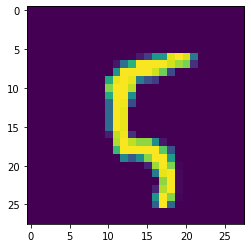

In [ ]:
i=100

print(ytoh[i])
plt.imshow(xt[i].reshape((28,28)))

Reconstruction loss:

In [ ]:
#########################################################################################################################################
#                                              reconstruction regularization loss
#########################################################################################################################################
def loss_fn(labels,logits):
  return tf.math.reduce_sum(tf.math.squared_difference(labels,255.0 * logits))
#########################################################################################################################################

Model with reconstruction loss:

In [ ]:
def model2(**kwargs):                                                            # Takes typ, branch and n_iter
    xin = Input((28,28,1))
    yin = Input((10,1))
    x = Conv2D(256,(9,9),strides=(1,1),padding="Valid",activation="relu")(xin)
    x = Conv2D(256,(9,9),strides=(2,2),padding="Valid",activation="relu")(x)
    x = Reshape((6,6,32,8))(x)
    x = Rsh()(x)
    x = DR_GC(ocap=10,vecsize=16,branch=kwargs["branch"],typ = kwargs["typ"],n_iter = kwargs["n_iter"])(x)
    x = Rsh()(x)
    y = Lambda(lambda x: tf.math.reduce_euclidean_norm(x,axis=-1,keepdims=False),name = "svm")(x)
    x = Add()([x,tf.ones_like(x)])                                                          #Somehow boolean mask is not working
    x = Lambda(lambda x: tf.math.reduce_max(x[0] * x[1],axis=-2,keepdims=False))([yin, x])  #so this expensive 3 step process was used
    x = Add()([x,tf.ones_like(x)*-1])                                                        
    x = Flatten()(x)
    x = Dense(512,activation="relu")(x)
    x = Dense(1024,activation="relu")(x)
    x = Dense(784,activation="sigmoid")(x)
    x = Reshape((28,28,1),name = "reconstruction")(x)
    return tf.keras.Model(inputs=[xin,yin],outputs=[y,x])

Dummy run of model:

In [ ]:
m2 = model2(branch="mean",typ="paper",n_iter=6)
m2.compile(optimizer="adam",loss=[svm_hinge,loss_fn],loss_weights=[10000,0.0005],metrics=["acc"])
  

In [ ]:
m2.fit([xt,ytoh],[ytlab,xt],batch_size=256,epochs=10,validation_data=([xval,yvaloh],[yvallab,xval]))

Epoch 1/30
215/215 [==============================] - 161s 738ms/step - loss: 3126772.9306 - svm_loss: 253.9897 - reconstruction_loss: 1173753875.2593 - svm_acc: 0.5239 - reconstruction_acc: 0.7821 - val_loss: 919219.6875 - val_svm_loss: 58.7295 - val_reconstruction_loss: 663849664.0000 - val_svm_acc: 0.9736 - val_reconstruction_acc: 0.7921
Epoch 2/30
215/215 [==============================] - 157s 731ms/step - loss: 942626.7199 - svm_loss: 59.8518 - reconstruction_loss: 688217218.6667 - svm_acc: 0.9674 - reconstruction_acc: 0.7912 - val_loss: 889293.1250 - val_svm_loss: 56.3819 - val_reconstruction_loss: 650948800.0000 - val_svm_acc: 0.9800 - val_reconstruction_acc: 0.7912
Epoch 3/30
215/215 [==============================] - 157s 732ms/step - loss: 898632.1435 - svm_loss: 56.3409 - reconstruction_loss: 670445741.9259 - svm_acc: 0.9793 - reconstruction_acc: 0.7920 - val_loss: 876773.8125 - val_svm_loss: 56.6650 - val_reconstruction_loss: 620246976.0000 - val_svm_acc: 0.9772 - val_reco

KeyboardInterrupt: ignored

In [ ]:
def lrs(epoch, alpha):
  return alpha * 0.8

m2.fit([xt,ytoh],[ytlab,xt],batch_size=256,epochs=5,validation_data=([xval,yvaloh],[yvallab,xval]),callbacks = [tf.keras.callbacks.LearningRateScheduler(lrs)])

Epoch 1/5
215/215 [==============================] - 157s 733ms/step - loss: 728964.6875 - svm_loss: 52.8127 - reconstruction_loss: 401673760.0000 - svm_acc: 0.9945 - reconstruction_acc: 0.7994 - val_loss: 729598.0625 - val_svm_loss: 53.4934 - val_reconstruction_loss: 389328608.0000 - val_svm_acc: 0.9906 - val_reconstruction_acc: 0.7999
Epoch 2/5
215/215 [==============================] - 157s 732ms/step - loss: 720017.8750 - svm_loss: 52.5645 - reconstruction_loss: 388745056.0000 - svm_acc: 0.9959 - reconstruction_acc: 0.7999 - val_loss: 721904.5000 - val_svm_loss: 53.3363 - val_reconstruction_loss: 377082176.0000 - val_svm_acc: 0.9912 - val_reconstruction_acc: 0.7994
Epoch 3/5
215/215 [==============================] - 157s 732ms/step - loss: 713155.8125 - svm_loss: 52.3536 - reconstruction_loss: 379239040.0000 - svm_acc: 0.9967 - reconstruction_acc: 0.8003 - val_loss: 717464.0625 - val_svm_loss: 53.4085 - val_reconstruction_loss: 366758784.0000 - val_svm_acc: 0.9908 - val_reconstruc

Reconstructing Image:

[0.04139557 0.22943091 0.12608466 0.080221   0.18641585 0.04747153
 0.11164813 0.5412749  0.11047253 0.2010613 ] 
 Class:7
25450800.0


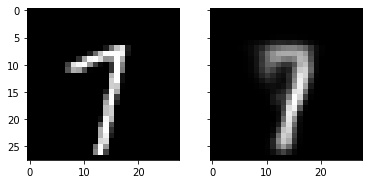

In [ ]:
i = 42

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(xt[i].reshape(28,28),cmap="gray")
plt.imshow(m2.predict([xt[i:i+1],ytoh[i:i+1]])[1][0].reshape((28,28)),cmap="gray")
print(m2.predict([xt[i:i+1],ytoh[i:i+1]])[0][0],"\n","Class:{}".format(np.argmax(m2.predict([xt[i:i+1],ytoh[i:i+1]])[0][0])))
print(np.sum((m2.predict([xt[i:i+1],ytoh[i:i+1]])[0][0] - xt[i])**2))

Travelling Latent Space:

In [ ]:
def model3():
  xin = Input((16))
  x = Dense(512,activation="relu")(xin)
  x = Dense(1024,activation="relu")(x)
  x = Dense(784,activation="sigmoid")(x)
  x = Reshape((28,28),name = "reconstruction")(x)
  return tf.keras.Model(inputs=[xin],outputs=[x])

In [ ]:
def model4(**kwargs):
  xin = Input((28,28,1))
  x = Conv2D(256,(9,9),strides=(1,1),padding="Valid",activation="relu")(xin)
  x = Conv2D(256,(9,9),strides=(2,2),padding="Valid",activation="relu")(x)
  x = Reshape((6,6,32,8))(x)
  x = Rsh()(x)
  x = DR_GC(ocap=10,vecsize=16,branch=kwargs["branch"],typ = kwargs["typ"],n_iter = kwargs["n_iter"])(x)
  x = Rsh()(x)
  return tf.keras.Model(inputs = [xin],outputs = [x])

In [ ]:
w_list = []
for i in range(5):
  w_list.append(m2.weights[i].numpy())

m4 = model4(branch="mean",typ="paper",n_iter=6)
m4.set_weights(w_list)

In [ ]:
w_list = []
for i in range(6):
  w_list.append(m2.weights[i-6].numpy())

m3 = model3()
m3.set_weights(w_list)

In [ ]:
latent = m4.predict(xt[:1000])

In [ ]:
dict = {}
for i in range(10):
  dict[i] = [np.zeros((5,16)),np.ones(5)*1000000000000]

for i in range(1000):
  sc = np.sum(np.square(m3.predict(latent[i][yt[i]].reshape((1,16))) - xt[i]))
  if(np.any(dict[yt[i]][1]>sc)):
    dict[yt[i]][0][np.argmax(dict[yt[i]][1] > sc )] = latent[i][yt[i]]
    dict[yt[i]][1][np.argmax(dict[yt[i]][1] > sc)] = sc
  else:
    continue

In [ ]:
print(dict[0])

[array([[-9.89588276e-02,  4.03080098e-02, -7.02419505e-02,
        -1.47797585e-01, -1.46575674e-01,  1.65072661e-02,
        -1.58099085e-01, -1.19749546e-01, -7.38413855e-02,
        -1.24573201e-01, -1.39850527e-01,  1.50076732e-01,
         2.02856302e-01, -1.65528581e-01,  6.74963370e-02,
        -2.21758515e-01],
       [-2.83557456e-02,  5.58071695e-02, -1.35050952e-01,
        -1.77215144e-01, -1.00355580e-01, -3.43861198e-03,
        -9.44606066e-02, -8.48797485e-02, -1.14929713e-01,
        -6.67405277e-02, -1.24375589e-01,  8.43783170e-02,
         2.20597729e-01, -1.41641185e-01,  6.32080510e-02,
        -7.03693405e-02],
       [-5.96273988e-02,  6.76877052e-02, -4.59847562e-02,
        -2.21903801e-01, -1.38656780e-01, -1.28505183e-02,
        -2.13812962e-01, -6.44591823e-02, -1.08726703e-01,
        -8.83824602e-02, -1.38562992e-01,  9.21126381e-02,
         1.88303784e-01, -2.04970285e-01,  5.77248335e-02,
        -1.85256049e-01],
       [-6.44664168e-02,  6.63069636

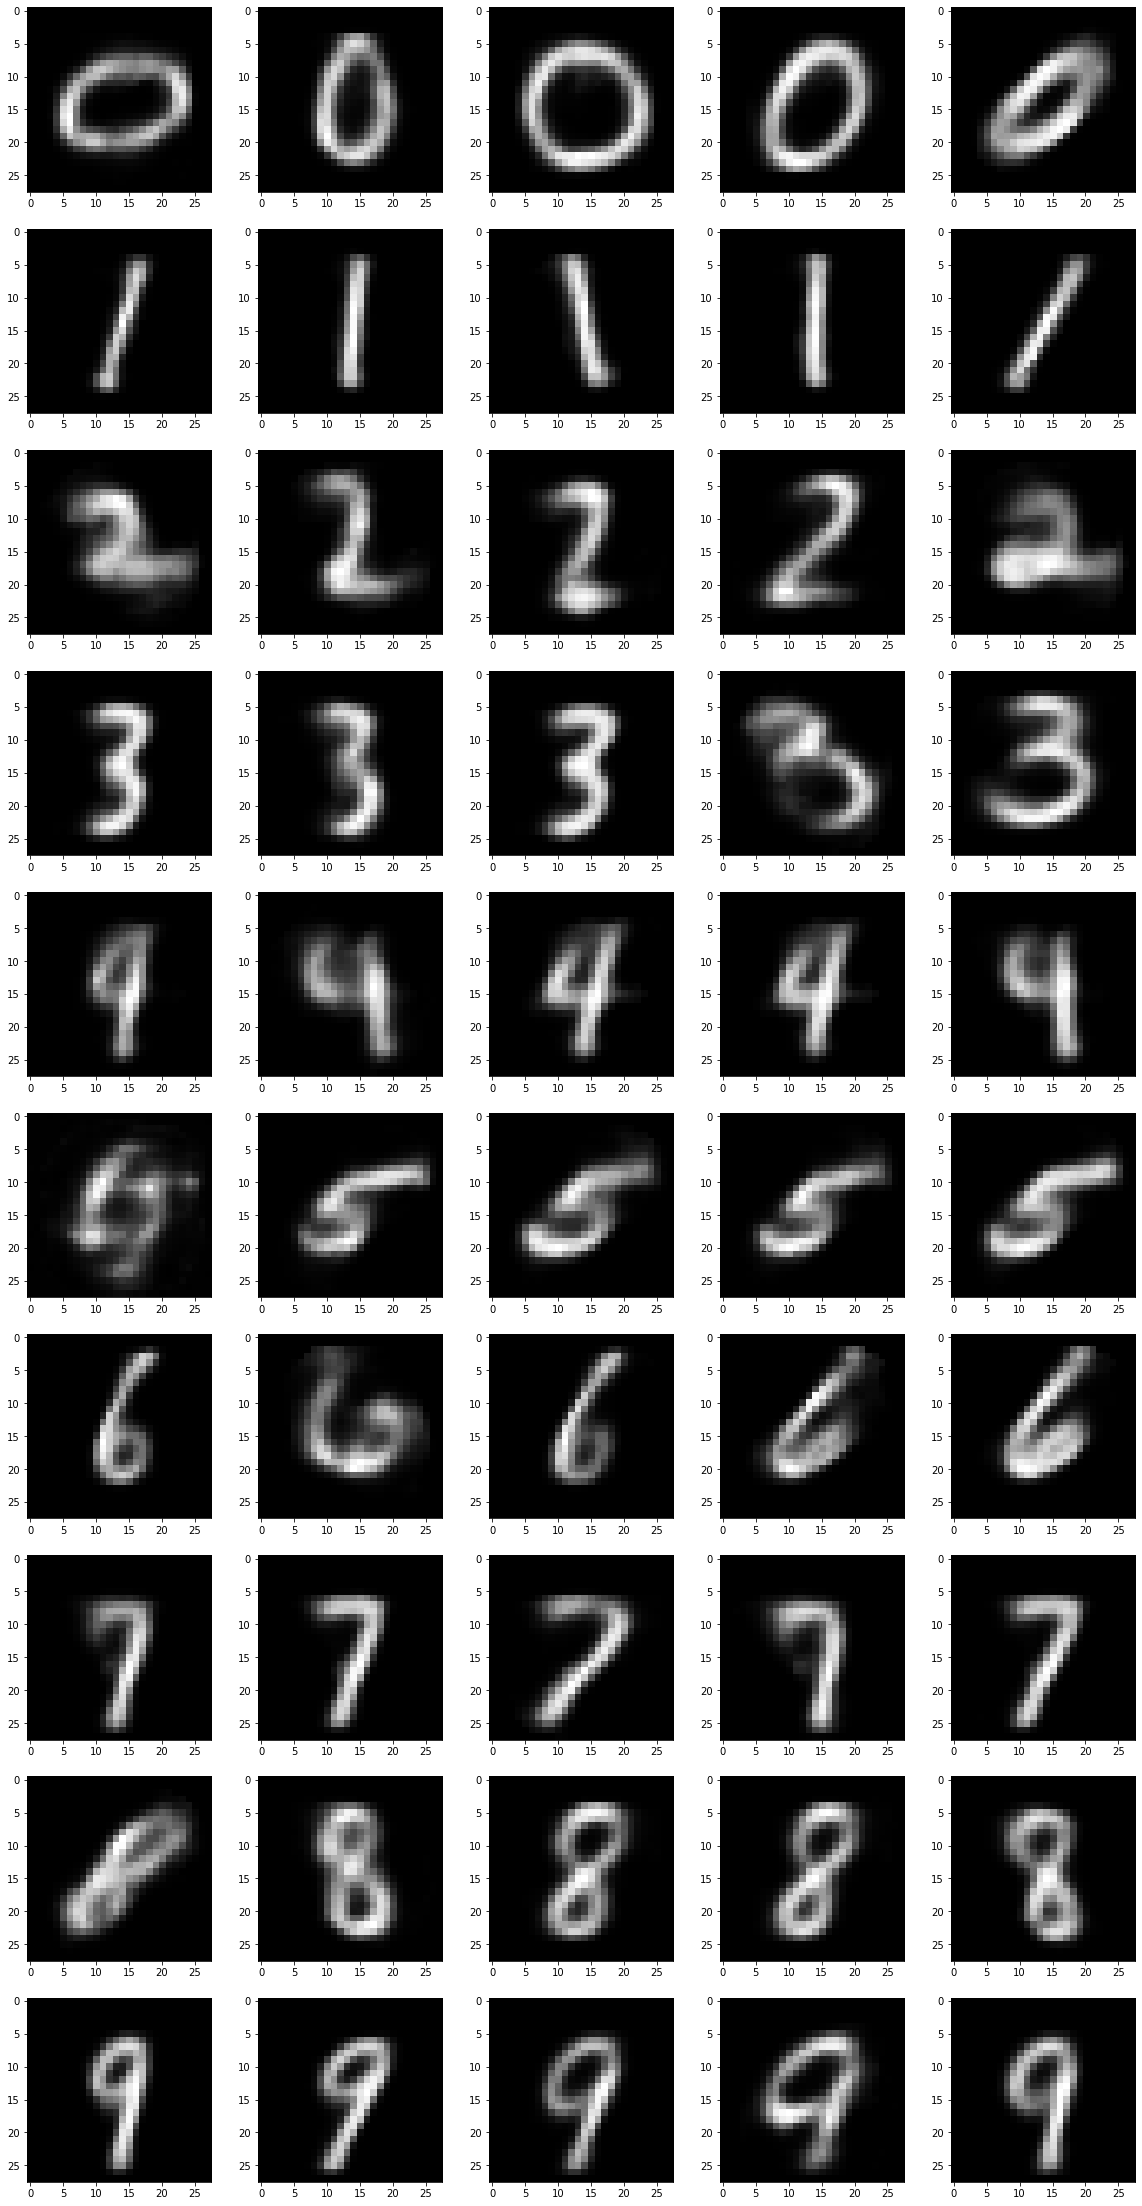

In [ ]:
fig,ax = plt.subplots(10,5,figsize = (20,40))

for i in range(50):
  a = dict[i//5][0][i%5].reshape(1,16)
  ax[i//5,i%5].imshow(m3.predict(a).reshape(28,28),cmap="gray")

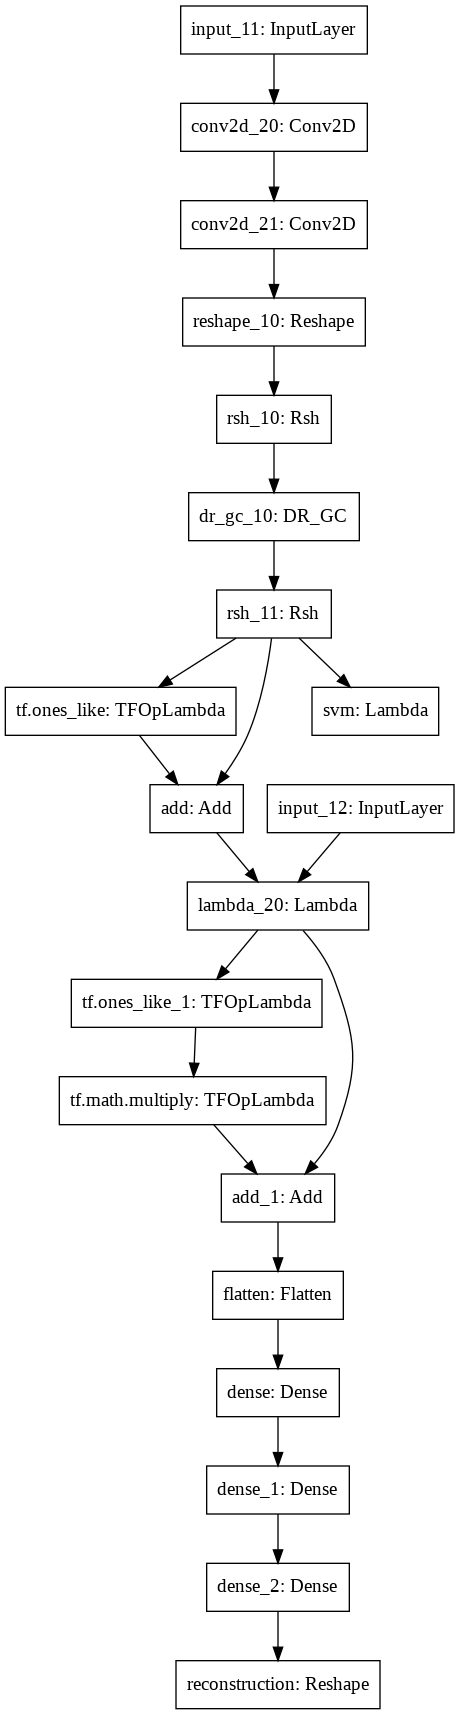

In [ ]:
plot_model(m2)